# Avocado Prices Notebook

The goal of this notebook is to build a forecast model for avocado prices. I'll focus on the price as the output and use various volume measures as the exogenous variables. For this notebook I'll be looking at the Total US region but that could easily be re-run for an inidividual location.

## Import Libraries

In [87]:
import pandas as pd
import calendar, time
import datetime as dt
from datetime import date
from pandas.tseries.offsets import DateOffset
import numpy as np
from statsmodels.tsa.stattools import adfuller
import string, re 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests

import pandas_profiling

%run -i 'timeseriesfunctions.py'

import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

# Data Clean and Process

In [3]:
df = pd.read_csv('avocado.csv')

df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [4]:
df.drop(columns = ['Unnamed: 0','year'],inplace=True)

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)

In [6]:
df.sort_index(inplace=True)

In [7]:
df.head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,region
Date,,,,,,,,,,,
2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.0,organic,Southeast
2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.0,organic,Chicago
2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.0,organic,HarrisburgScranton
2015-01-04,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.0,conventional,Pittsburgh
2015-01-04,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.0,organic,Boise


In [8]:
df.columns

Index(['AveragePrice', 'Total Volume', '4046', '4225', '4770', 'Total Bags',
       'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'region'],
      dtype='object')

In [9]:
#Going to drop XL bags as we can always calculate it from total, small and large
df.drop(columns = ['XLarge Bags'],inplace=True)

In [10]:
#No null values
df.isnull().sum()

AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
type            0
region          0
dtype: int64

In [11]:
df.describe()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags
count,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04
mean,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04
std,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05
min,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02
50%,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03
75%,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04
max,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06


First I want to look at region and type and then decide how I want to treat them.

In [12]:
df.type.value_counts()

conventional    9126
organic         9123
Name: type, dtype: int64

There are two classes of avocados to look at, conventional and organic

In [13]:

df.region.value_counts()

Charlotte              338
Pittsburgh             338
Albany                 338
BaltimoreWashington    338
Plains                 338
Boise                  338
SouthCarolina          338
California             338
Portland               338
West                   338
TotalUS                338
Indianapolis           338
LasVegas               338
Louisville             338
StLouis                338
RichmondNorfolk        338
Philadelphia           338
Atlanta                338
Boston                 338
Northeast              338
NewYork                338
Seattle                338
Spokane                338
Sacramento             338
Columbus               338
RaleighGreensboro      338
DallasFtWorth          338
MiamiFtLauderdale      338
Nashville              338
Syracuse               338
NewOrleansMobile       338
SouthCentral           338
Midsouth               338
NorthernNewEngland     338
Denver                 338
Houston                338
GreatLakes             338
L

For the purposes of this project I'm going to focus on TotalUS prices but simply by switching the region name this project could be repated for any individual region

## Pickle Checkpoint

In [14]:
df = df.loc[df['region']== 'TotalUS']
df_organic = df.loc[df['type'] == 'organic']
df_conv = df.loc[df['type'] == 'conventional']
#Pickle Checkpoint
df_organic.to_pickle('TotalUS_Organic')
df_conv.to_pickle('TotalUS_Conv')

# EDA
## Organic Avocados
### Visualization

In [62]:
df_org = pd.read_pickle('TotalUS_Organic')


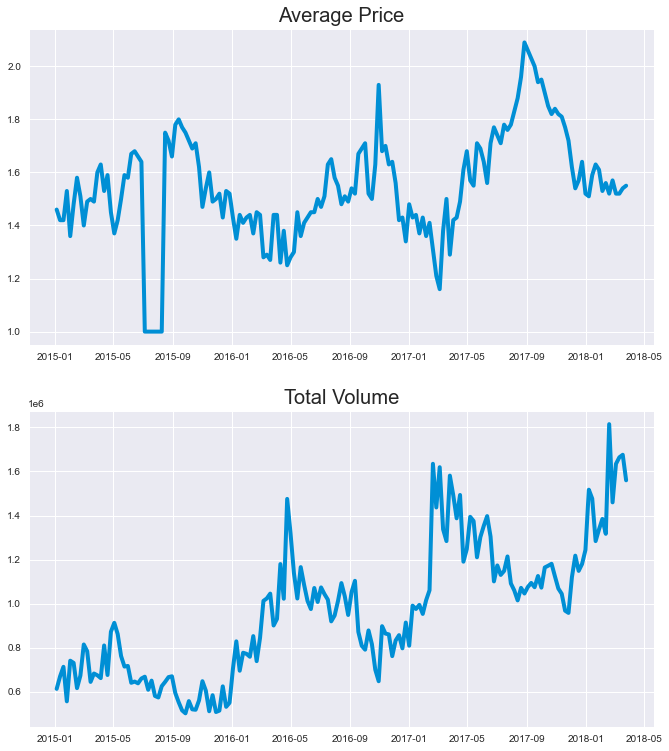

In [63]:
# graphing the prices for our avocado data
fig, (ax1, ax2) = plt.subplots(2,figsize=(10,12))

ax1.plot(df_org.index,df_org['AveragePrice'])
ax1.set_title('Average Price')

ax2.plot(df_org.index,df_org['Total Volume'])
ax2.set_title('Total Volume')




plt.show()

It looks like we might have an issue with the summer of 2015 data. I'm going backfill the prices that are 1 there.

In [64]:
df_org.loc[df_org['AveragePrice'] == 1]

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,type,region
Date,,,,,,,,,,
2015-07-05,1.0,668233.0,205073.0,304597.0,6251.0,152309.0,88261.0,64048.0,organic,TotalUS
2015-07-12,1.0,608845.0,178871.0,267353.0,5093.0,157526.0,80220.0,77305.0,organic,TotalUS
2015-07-19,1.0,650389.0,159752.0,317728.0,4758.0,168149.0,81667.0,86482.0,organic,TotalUS
2015-07-26,1.0,580826.0,169940.0,266249.0,4391.0,140244.0,71807.0,68436.0,organic,TotalUS
2015-08-02,1.0,573873.0,164126.0,263359.0,5115.0,141271.0,93120.0,48151.0,organic,TotalUS
2015-08-09,1.0,625259.0,170184.0,269330.0,6905.0,178838.0,126058.0,52779.0,organic,TotalUS


In [65]:
df_org.loc[df_org.index == '2015-06-28']

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,type,region
Date,,,,,,,,,,
2015-06-28,1.64,659947.03,192182.13,332739.27,5956.87,129068.76,80006.4,49062.36,organic,TotalUS


I'm going to set the weeks where the price was listed as 1.0 to the 1.64 value of the week preceeding.

In [66]:
df_org['AveragePrice']=df_org['AveragePrice'].apply(lambda x: 1.64 if x ==1.0 else x)

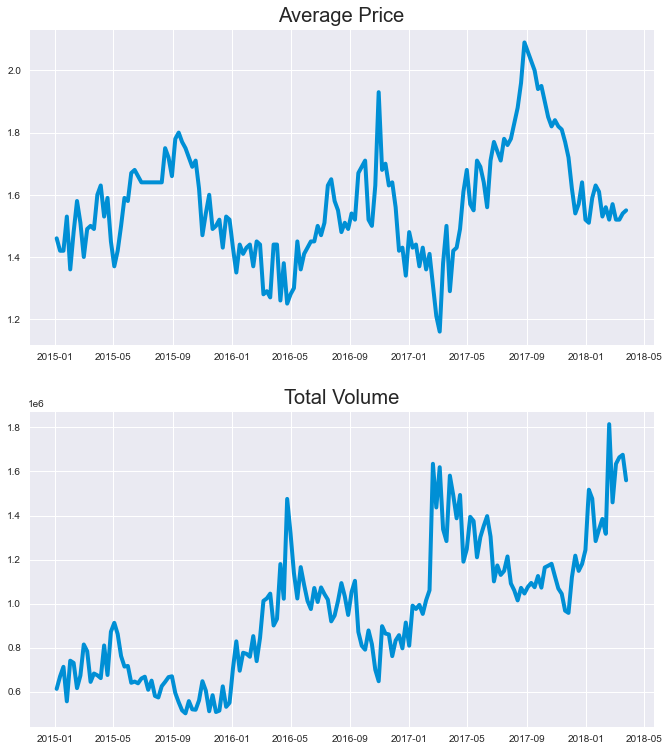

In [67]:
# graphing the prices for our avocado data
fig, (ax1, ax2) = plt.subplots(2,figsize=(10,12))

ax1.plot(df_org.index,df_org['AveragePrice'])
ax1.set_title('Average Price')

ax2.plot(df_org.index,df_org['Total Volume'])
ax2.set_title('Total Volume')




plt.show()

It looks like there might be an outlier for volume and price. Going to look at those more carefully. First I'll be focusing on organic avocados.

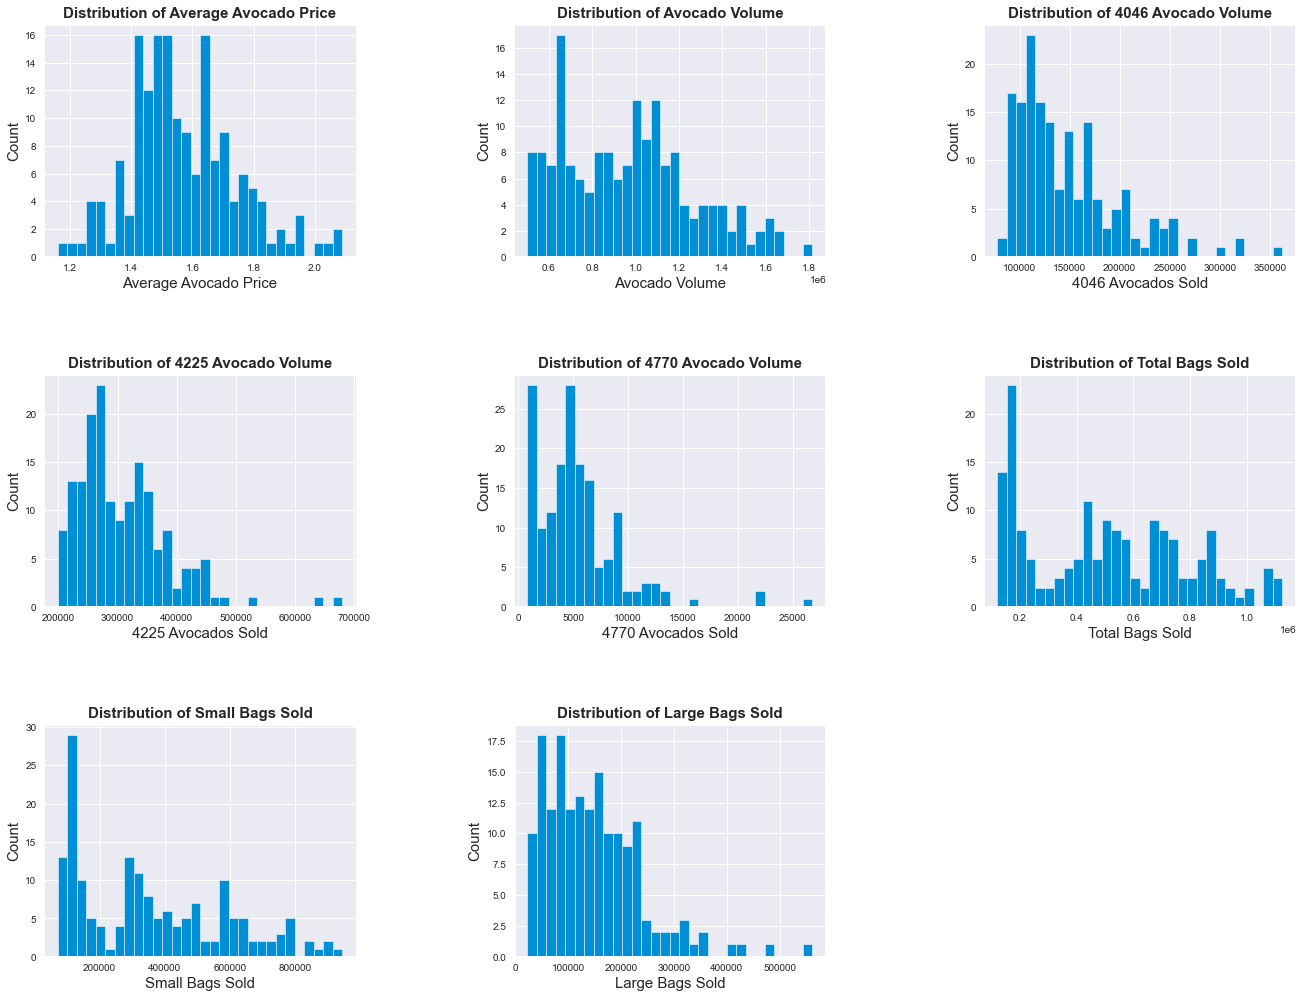

In [68]:
# Plots of the distribution of the organic avocado data
sns.set_style('darkgrid')
fig = plt.figure(figsize = (20,16))
fig.subplots_adjust(hspace = .5, wspace = 0.5)

ax1 = fig.add_subplot(331)
ax1.hist(df_org['AveragePrice'], bins = 30)
ax1.set_xlabel('Average Avocado Price', fontsize = 15)
ax1.set_ylabel('Count',fontsize = 15)
ax1.set_title('Distribution of Average Avocado Price',fontsize = 15,fontweight='bold')

ax2 = fig.add_subplot(332)
ax2.hist(df_org['Total Volume'], bins = 30)
ax2.set_xlabel('Avocado Volume', fontsize = 15)
ax2.set_ylabel('Count',fontsize = 15)
ax2.set_title('Distribution of Avocado Volume',fontsize = 15,fontweight='bold')

ax3 = fig.add_subplot(333)
ax3.hist(df_org['4046'], bins = 30)
ax3.set_xlabel('4046 Avocados Sold', fontsize = 15)
ax3.set_ylabel('Count',fontsize = 15)
ax3.set_title('Distribution of 4046 Avocado Volume',fontsize = 15,fontweight='bold')

ax4 = fig.add_subplot(334)
ax4.hist(df_org['4225'], bins = 30)
ax4.set_xlabel('4225 Avocados Sold', fontsize = 15)
ax4.set_ylabel('Count',fontsize = 15)
ax4.set_title('Distribution of 4225 Avocado Volume',fontsize = 15,fontweight='bold')

ax5 = fig.add_subplot(335)
ax5.hist(df_org['4770'], bins = 30)
ax5.set_xlabel('4770 Avocados Sold', fontsize = 15)
ax5.set_ylabel('Count',fontsize = 15)
ax5.set_title('Distribution of 4770 Avocado Volume',fontsize = 15,fontweight='bold')

ax6 = fig.add_subplot(336)
ax6.hist(df_org['Total Bags'], bins = 30)
ax6.set_xlabel('Total Bags Sold', fontsize = 15)
ax6.set_ylabel('Count',fontsize = 15)
ax6.set_title('Distribution of Total Bags Sold',fontsize = 15,fontweight='bold')

ax7 = fig.add_subplot(337)
ax7.hist(df_org['Small Bags'], bins = 30)
ax7.set_xlabel('Small Bags Sold', fontsize = 15)
ax7.set_ylabel('Count',fontsize = 15)
ax7.set_title('Distribution of Small Bags Sold',fontsize = 15,fontweight='bold')

ax8 = fig.add_subplot(338)
ax8.hist(df_org['Large Bags'], bins = 30)
ax8.set_xlabel('Large Bags Sold', fontsize = 15)
ax8.set_ylabel('Count',fontsize = 15)
ax8.set_title('Distribution of Large Bags Sold',fontsize = 15,fontweight='bold')

plt.show()

There are clearly some outliers that we need to adjust before we can dig in further.

In [69]:
quantile_list = [.9,.925,.95,.975,.99]


for i in quantile_list:
    print ('Avocado Volume at the', i, 'percentile is', round(df_org['Total Volume'].quantile(i),0))
    
for i in quantile_list:
    print ('Avocado Price at the', i, 'percentile is', round(df_org['AveragePrice'].quantile(i),0))

Avocado Volume at the 0.9 percentile is 1388774.0
Avocado Volume at the 0.925 percentile is 1466095.0
Avocado Volume at the 0.95 percentile is 1507732.0
Avocado Volume at the 0.975 percentile is 1631424.0
Avocado Volume at the 0.99 percentile is 1667937.0
Avocado Price at the 0.9 percentile is 2.0
Avocado Price at the 0.925 percentile is 2.0
Avocado Price at the 0.95 percentile is 2.0
Avocado Price at the 0.975 percentile is 2.0
Avocado Price at the 0.99 percentile is 2.0


I'm going to take the log of the volume columns and look at the distribution again.

In [70]:
columns = list(df_org.columns)

In [71]:
columns.pop(0)
columns.pop(-2)
columns.pop(-1)

'region'

In [72]:
for column in columns:
    title = 'Log ' + column
    df_org[title]=np.log(df_org[column] + .001)
    df_org[title]=df_org[title].clip(lower=0)

In [73]:
df_org.describe()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,Log Total Volume,Log 4046,Log 4225,Log 4770,Log Total Bags,Log Small Bags,Log Large Bags
count,169.000000,1.690000e+02,169.000000,169.000000,169.000000,1.690000e+02,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000
mean,1.568757,9.675657e+05,148404.667515,308284.424201,5409.545503,5.053699e+05,358176.323550,147170.631775,13.733491,11.852480,12.611371,8.350792,12.945295,12.551065,11.705245
std,0.173957,3.024823e+05,53212.205731,77183.319695,3914.029770,2.793308e+05,229695.844747,91714.155631,0.316575,0.323913,0.229111,0.739626,0.654352,0.727518,0.648747
min,1.160000,5.018149e+05,77759.930000,198874.090000,834.300000,1.198562e+05,71807.000000,22985.220000,13.125987,11.261382,12.200427,6.726594,11.694048,11.181737,10.042607
25%,1.440000,6.997633e+05,109023.660000,250138.660000,3195.150000,2.014203e+05,130418.730000,77963.170000,13.458497,11.599320,12.429771,8.069390,12.213149,11.778506,11.263992
50%,1.540000,9.678861e+05,132040.040000,287724.610000,4880.830000,4.955600e+05,319112.580000,131040.860000,13.782870,11.790860,12.569759,8.493071,13.113444,12.673299,11.783264
75%,1.670000,1.148617e+06,171054.380000,347488.780000,6707.820000,7.168287e+05,525280.480000,198548.780000,13.954069,12.049737,12.758488,8.811029,13.482592,13.171688,12.198790
max,2.090000,1.814930e+06,361996.840000,680037.450000,26765.780000,1.124622e+06,944572.500000,561530.390000,14.411557,12.799391,13.429903,10.194880,13.932957,13.758488,13.238421


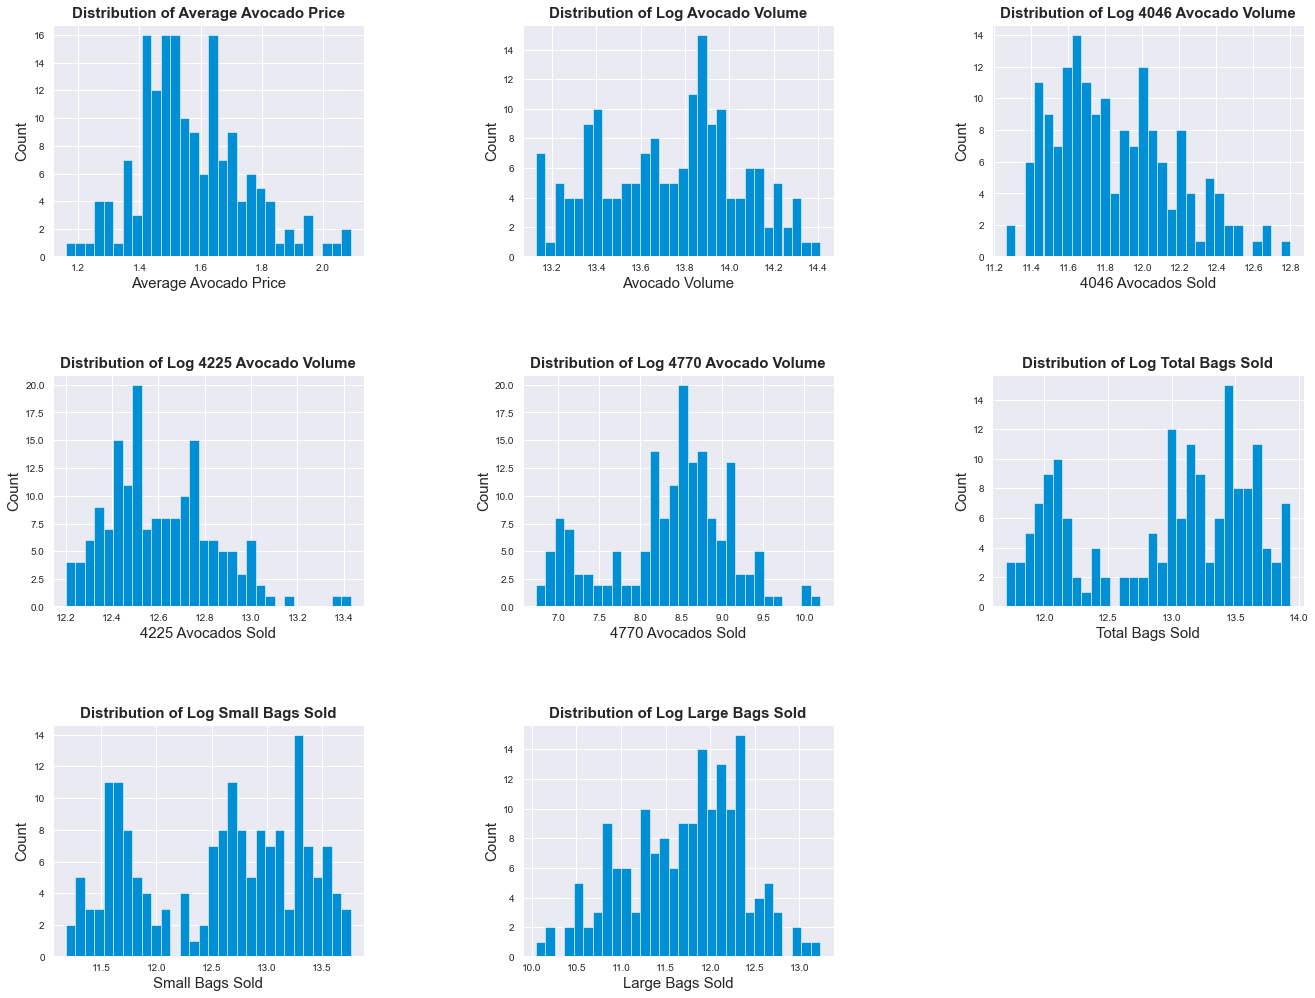

In [74]:
# Plots of the distribution of the sentiment data
sns.set_style('darkgrid')
fig = plt.figure(figsize = (20,16))
fig.subplots_adjust(hspace = .5, wspace = 0.5)

ax1 = fig.add_subplot(331)
ax1.hist(df_org['AveragePrice'], bins = 30)
ax1.set_xlabel('Average Avocado Price', fontsize = 15)
ax1.set_ylabel('Count',fontsize = 15)
ax1.set_title('Distribution of Average Avocado Price',fontsize = 15,fontweight='bold')

ax2 = fig.add_subplot(332)
ax2.hist(df_org['Log Total Volume'], bins = 30)
ax2.set_xlabel('Avocado Volume', fontsize = 15)
ax2.set_ylabel('Count',fontsize = 15)
ax2.set_title('Distribution of Log Avocado Volume',fontsize = 15,fontweight='bold')

ax3 = fig.add_subplot(333)
ax3.hist(df_org['Log 4046'], bins = 30)
ax3.set_xlabel('4046 Avocados Sold', fontsize = 15)
ax3.set_ylabel('Count',fontsize = 15)
ax3.set_title('Distribution of Log 4046 Avocado Volume',fontsize = 15,fontweight='bold')

ax4 = fig.add_subplot(334)
ax4.hist(df_org['Log 4225'], bins = 30)
ax4.set_xlabel('4225 Avocados Sold', fontsize = 15)
ax4.set_ylabel('Count',fontsize = 15)
ax4.set_title('Distribution of Log 4225 Avocado Volume',fontsize = 15,fontweight='bold')

ax5 = fig.add_subplot(335)
ax5.hist(df_org['Log 4770'], bins = 30)
ax5.set_xlabel('4770 Avocados Sold', fontsize = 15)
ax5.set_ylabel('Count',fontsize = 15)
ax5.set_title('Distribution of Log 4770 Avocado Volume',fontsize = 15,fontweight='bold')

ax6 = fig.add_subplot(336)
ax6.hist(df_org['Log Total Bags'], bins = 30)
ax6.set_xlabel('Total Bags Sold', fontsize = 15)
ax6.set_ylabel('Count',fontsize = 15)
ax6.set_title('Distribution of Log Total Bags Sold',fontsize = 15,fontweight='bold')

ax7 = fig.add_subplot(337)
ax7.hist(df_org['Log Small Bags'], bins = 30)
ax7.set_xlabel('Small Bags Sold', fontsize = 15)
ax7.set_ylabel('Count',fontsize = 15)
ax7.set_title('Distribution of Log Small Bags Sold',fontsize = 15,fontweight='bold')

ax8 = fig.add_subplot(338)
ax8.hist(df_org['Log Large Bags'], bins = 30)
ax8.set_xlabel('Large Bags Sold', fontsize = 15)
ax8.set_ylabel('Count',fontsize = 15)
ax8.set_title('Distribution of Log Large Bags Sold',fontsize = 15,fontweight='bold')

plt.show()

In [79]:
df_org.columns

Index(['AveragePrice', 'Total Volume', '4046', '4225', '4770', 'Total Bags',
       'Small Bags', 'Large Bags', 'type', 'region', 'Log Total Volume',
       'Log 4046', 'Log 4225', 'Log 4770', 'Log Total Bags', 'Log Small Bags',
       'Log Large Bags'],
      dtype='object')

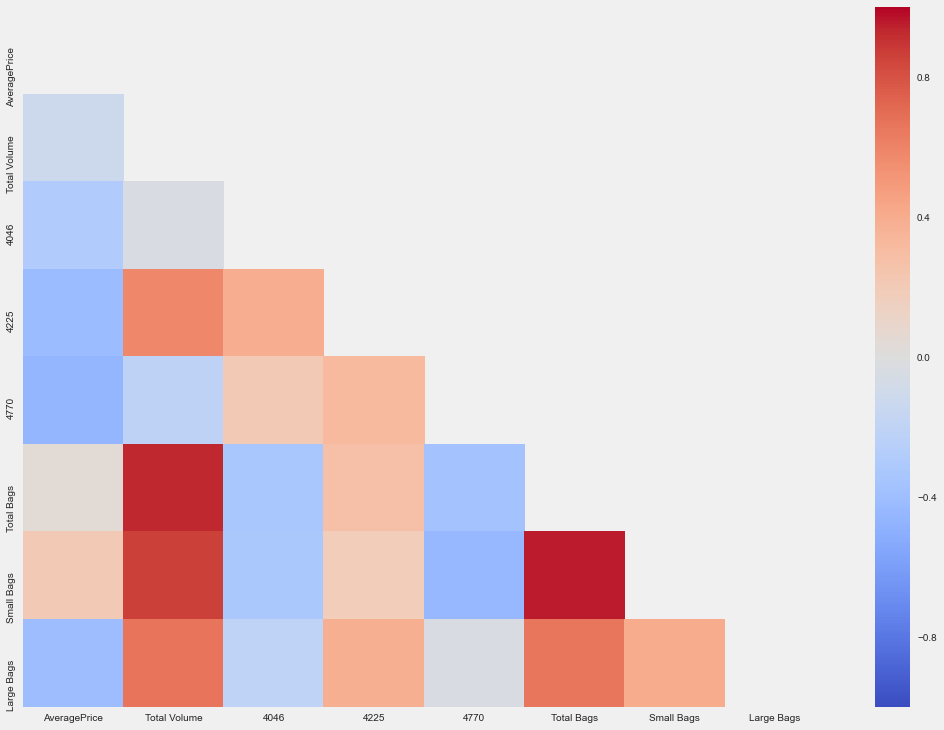

In [80]:
df_org_log = df_org.filter(['AveragePrice','Log Total Volume',
       'Log 4046', 'Log 4225', 'Log 4770', 'Log Total Bags', 'Log Small Bags',
       'Log Large Bags'], axis=1)
df_org = df_org.filter(['AveragePrice', 'Total Volume', '4046', '4225', '4770', 'Total Bags',
       'Small Bags', 'Large Bags'],axis=1)


f, ax = plt.subplots(figsize=(16, 12))
matrix = np.triu(df_org.corr())
sns.heatmap(df_org.corr(), vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask = matrix)

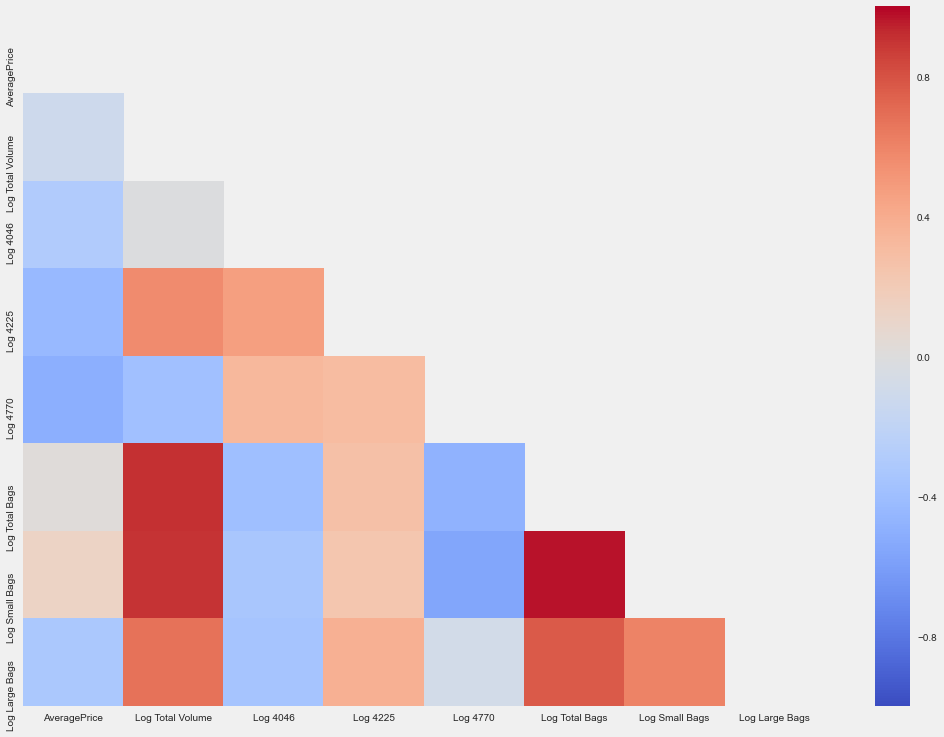

In [81]:
f, ax = plt.subplots(figsize=(16, 12))
matrix = np.triu(df_org_log.corr())
sns.heatmap(df_org_log.corr(), vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask = matrix)

Based on the heatmaps, I'm going to focus on the non logged volume as there isnt a need to ensure normality of the distribution. I'm also going to include 4046 and 4770 as potential exogenous variables. The other volume metrics are very highly correlated so I feel comfortable dropping them.

I'm going to set the averageprice to 1.64 where it is 0.

In [82]:
df_org = df_org.filter(['AveragePrice','Total Volume','4046','4770'], axis =1)

In [83]:
df_org.head()

,AveragePrice,Total Volume,4046,4770
Date,,,,
2015-01-04,1.46,612910.15,233286.13,4370.99
2015-01-11,1.42,669528.88,270966.74,3830.42
2015-01-18,1.42,713120.00,254319.58,4020.85
2015-01-25,1.53,556368.86,207494.87,4753.87
2015-02-01,1.36,740896.97,302561.47,5852.28


## Time Series Stats Tests

In [86]:
#Set alpha
alpha = .05

#Perform the Dickey-Fuller Test
DickeyFullerTest(df_org['AveragePrice'],alpha)

Our p-value of 0.043 is less than our alpha of 0.05 so we reject the null hypothesis that there is a unit root. The data is stationary.

Dickey-Fuller test: 

Test Statistic                  -2.91768
p-value                          0.04333
#Lags Used                      10.00000
Number of Observations Used    158.00000
dtype: float64


In [95]:
#Perform the granger causality test
maxlag=5
df_grang = df_org.filter(['AveragePrice','Total Volume'],axis=1)
granger = grangercausalitytests(df_grang,maxlag=maxlag)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6529  , p=0.0577  , df_denom=165, df_num=1
ssr based chi2 test:   chi2=3.7193  , p=0.0538  , df=1
likelihood ratio test: chi2=3.6787  , p=0.0551  , df=1
parameter F test:         F=3.6529  , p=0.0577  , df_denom=165, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7360  , p=0.1795  , df_denom=162, df_num=2
ssr based chi2 test:   chi2=3.5791  , p=0.1670  , df=2
likelihood ratio test: chi2=3.5413  , p=0.1702  , df=2
parameter F test:         F=1.7360  , p=0.1795  , df_denom=162, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3462  , p=0.2614  , df_denom=159, df_num=3
ssr based chi2 test:   chi2=4.2165  , p=0.2390  , df=3
likelihood ratio test: chi2=4.1638  , p=0.2443  , df=3
parameter F test:         F=1.3462  , p=0.2614  , df_denom=159, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0541  , p=0.3813  

It appears that we cannot reject the null that there is no causality at a p level of 0.05, howver if we chose a p value of 0.1 we would reject the null for 1 lag.